# Running G-VAMP and the State Evolution equations for complex Gaussian matrices.

This is based on the TrAMP package

In [1]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt
import time, pickle
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
#Loading the necessary packages from TrAMP
from tramp.algos import StateEvolution, LogProgress, JoinCallback, NoisyInit, ConstantInit, EarlyStopping, CustomInit
from tramp.priors import GaussianPrior
from tramp.variables import (
    SISOVariable as V, SIMOVariable, MISOVariable, SILeafVariable as O, MILeafVariable
)
from tramp.likelihoods import ModulusLikelihood

#Some customized classes
from Custom_Class.Custom_Channels import ComplexMarchenkoPasturChannel
from Custom_Class.Custom_Callbacks import EarlyStopping_Custom

INFO:root:Generating grammar tables from /usr/lib/python3.6/lib2to3/Grammar.txt
INFO:root:Generating grammar tables from /usr/lib/python3.6/lib2to3/PatternGrammar.txt


In [3]:
def mse(alpha, N = 5000, max_iter = 1000):
    """
    Computes the MSE of State Evolution and of EP/GVAMP using the TrAMP package.
    The State Evolution equations are run from the particular finite-size instance
    """ 
    #Building the priors (with a shape (2,N) because we have complex variables)
    prior_z_student = GaussianPrior(size=(2, N), mean=5e-3 ) #We add a small mean in the prior to break the symmetry, but not to generate the data !
    prior_z_teacher = GaussianPrior(size=(2, N), mean=0.)

    #Building the sensing matrix A from ComplexGaussian ensemble
    M = int(alpha * N)
    A = ComplexGaussianEnsemble(M,N).generate() 
    
    #Building the teacher and student models
    model_teacher = prior_z_teacher @ V(id="z") @ ComplexLinearChannel(A, name="A") @ V(id="Az") @ ModulusChannel() @ O(id="y")
    model_student = prior_z_student @ V(id="z") @ ComplexLinearChannel(A, name="A") @ V(id="Az") @ ModulusChannel() @ O(id="y")
    teacher = model_teacher.to_model()
    student = model_student.to_model()

    #Running EP/GVAMP
    scenario = TeacherStudentScenario(teacher=teacher, student=student, x_ids=["z"])
    scenario.setup()
    records_ep = scenario.run_ep(max_iter=max_iter)
    
    #Building and running the state evolution (with the numerical instance of the sensing matrix)
    se = StateEvolution(student)
    se.iterate(max_iter=max_iter, initializer=None) #We can also change to an informed initialization using initializer
    records_se = se.get_variables_data('z')
    
    return records_ep, records_se

In [4]:
def mse_se_analytical(alpha, informed = False, verbosity = 0):
    """
    Computes the MSE of State Evolution for complex Gaussian matrices using the TrAMP package.
    The State Evolution equations are run on the analytic limit spectral density.
    """ 
    tol = 1e-7
    mean = 0.
    damping = 0.3 
    if not(informed): #We add a small mean for the uninformed case, to break the symmetry
        mean = 5e-3 
    size = (2,None) #Since we have an analytical channel, size = None in the real case, (2,None) in the complex case
    
    #Building the model
    prior_z = GaussianPrior(size=size,mean=mean)
    output = ModulusLikelihood(y=None, y_name="y")
    model = prior_z @ V(id="z") @ ComplexMarchenkoPasturChannel(alpha=alpha, name="A") @ V(id="Az") @ output #build model
    model = model.to_model()
    se = StateEvolution(model)
    
    #Uninformed and informed initializations
    if not(informed):
        callback = EarlyStopping(tol=tol, min_variance=1e-12, max_increase = 0.5)
        a0 = 0.
    if informed:
        #We take at least 100 iterations to make sure we do not have a fake convergence
        callback = EarlyStopping_Custom(tol=tol, min_variance=1e-12, max_increase = 0.5, min_iterations = 100)
        a0 = 1e3

    #Running the State Evolution
    a_init = [("z", "bwd", a0),("Az","bwd",a0)]
    if verbosity >= 1:
            callback  = JoinCallback([callback,LogProgress(ids = "all", every = 50)])
    initializer = CustomInit(a_init=a_init)
    se.iterate(max_iter = 5000, callback=callback, initializer=initializer,damping=damping)
        
    records = se.get_variables_data('z')
    return records

In [12]:
#An example point, just after the full recovery transition, with an informed initialization.
mse_se_analytical(alpha=2.01, informed = True, verbosity=1)

INFO:tramp.algos.message_passing:init message dag with CustomInit(a_init={'z': {'bwd': 1000.0}, 'Az': {'bwd': 1000.0}},b_init={},a=0,b=0)
INFO:tramp.algos.message_passing:f_0->z damping=0.3
INFO:tramp.algos.message_passing:f_1->Az damping=0.3
INFO:tramp.algos.message_passing:z<-f_1 damping=0.3
INFO:tramp.algos.message_passing:Az<-f_2 damping=0.3
INFO:tramp.algos.callbacks:iteration=1/5000
INFO:tramp.algos.callbacks:id=z v=0.001
INFO:tramp.algos.callbacks:id=Az v=0.001
INFO:tramp.algos.callbacks:iteration=51/5000
INFO:tramp.algos.callbacks:id=z v=0.001
INFO:tramp.algos.callbacks:id=Az v=0.001
INFO:tramp.algos.callbacks:iteration=101/5000
INFO:tramp.algos.callbacks:id=z v=0.001
INFO:tramp.algos.callbacks:id=Az v=0.000
INFO:tramp.algos.callbacks:iteration=151/5000
INFO:tramp.algos.callbacks:id=z v=0.001
INFO:tramp.algos.callbacks:id=Az v=0.000
INFO:tramp.algos.callbacks:iteration=201/5000
INFO:tramp.algos.callbacks:id=z v=0.001
INFO:tramp.algos.callbacks:id=Az v=0.000
INFO:tramp.algos.cal

{'z': {'tau': 1.0, 'v': 1.868114070915137e-05}}

In [13]:
#A plot using the data from the files run_se_complex_gaussian and run_gvamp_complex_gaussian.
def plot_se_vs_ep():
    
    #Loading the data
    #Analytical State Evolution data
    filename = "Data/results_se_complex_gaussian.pkl"
    infile = open(filename,'rb')
    results = pickle.load(infile)
    infile.close()
    alphas_se = {'informed':results['alphas_informed'],'uninformed':results['alphas_uninformed']}
    mses_uninformed = results['mses_uninformed']
    mses_informed = results['mses_informed']

    #Loading GVAMP data
    filename = "Data/results_gvamp_complex_gaussian.pkl"
    infile = open(filename,'rb')
    results = pickle.load(infile)
    infile.close()
    alphas_gvamp = results['alphas']
    mses_gvamp = {'all':{'mean':results['mses_gvamp_mean_all'],'std':results['mses_gvamp_std_all']},'cv_only':{'mean':results['mses_gvamp_mean_cv_only'],'std':results['mses_gvamp_std_cv_only']}}
    
    plt.rcParams.update({'font.size': 12})
    golden = (1+np.sqrt(5.))/2
    width = 17
    fig, ax = plt.subplots(figsize=(width,width/(1+golden)))
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'MSE')
    ax.set_title(r'Complex Gaussian matrices')

    ax.plot([1.,1.],[-0.5,1.5],linestyle='--',color='red',zorder=0)
    ax.plot([0.,3],[1.,1.],linestyle='--',color='black',zorder=0)
    ax.plot([0.,3],[0.,0.],linestyle='--',color='black',zorder=0)

    ax.plot(alphas_se['uninformed'],mses_uninformed, label = "State Evolution (Uninformed solution)",zorder = 2, linewidth=3)
    ax.plot(alphas_se['informed'],mses_informed, label = "State Evolution (Informed solution)",linewidth=3, zorder = 1, color = 'orange')
    eb = ax.errorbar(alphas_gvamp, mses_gvamp['all']['mean'], yerr =  mses_gvamp['all']['std'], label = "GAMP/EP", zorder = 4, color = 'red', fmt='o', markersize=5,capsize = 2)
    eb[-1][0].set_linestyle('--')

    ax.legend(fancybox=True, loc='lower left')
    ax.set_xlim(0.4,2.3)

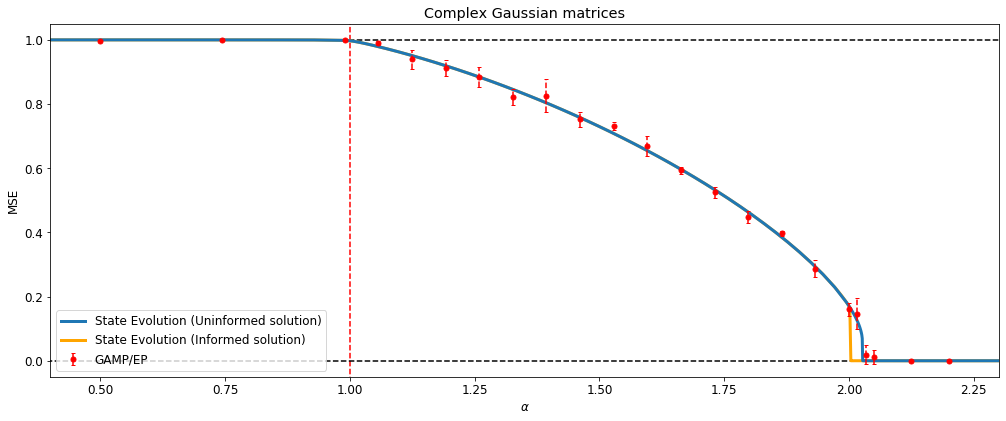

In [14]:
plot_se_vs_ep()